<a href="https://colab.research.google.com/github/davideliseo/lab-3-ia/blob/main/lab_3_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formular un problema (objetivos, alcancey áreas de aplicación) que requiera un sistema de clasificación multiclase, con un dataset propio, creado y etiquetado con algún sw de etiquetado (se recomienda Makesense o Roboflow).
Requerimientos iniciales:
1. El dataset debe representar un conjunto de imágenes propias y que no correspondan a ningún dataset tradicional o
que exista.
2. El numero de clases debe ser al menos 10.
3. El numero de imágenes por clases debe ser al menos 200-300
4. Una vez formulado el dataset, desarrollar un EDA y considerar un balanceamiento de las clases y un proceso de Data Augmentation.
5. El desarrollo de la solución, debe contemplar una Fase 1: que corresponde a un modelo propio creado y la Fase 2: Aplicación de Transfer Learning con al menos 4 modelos preentrenados.
5. El proceso de EDA, Entrenamiento, Evaluación, Análisis de resultados debe 
desarrollarse tanto para la Fase 1 como la Fase 2.
6. La Fase 3 comprenderá a la selección del modelo mas adecuado (en base a un análisis y adecuada fundamentación de la selección), formular estrategias de mejoramiento del modelo y ejecutarlas sobre la solución mas adecuada.
7. Una Fase 4 comprenderá incorporar un front-end que actúe como detector en línea, con una adecuada interfase de ingreso de datos a ingresar al detector. Las imágenes pueden ser obtenida a partir de una dirección de internet o recuperada desde disco (local desde PC, Notebook o celular).

1. https://www.tensorflow.org/tutorials/load_data/images
2. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
3. https://www.tensorflow.org/api_docs/python/tf/data/Dataset




# **Librerias**

1. https://www.tensorflow.org/tutorials/load_data/images
2. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
3. https://www.tensorflow.org/api_docs/python/tf/data/Dataset




# **Librerias**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import itertools
import os
import h5py
from PIL import Image

## 1. Formulación del dataset

In [ ]:
from google.colab import drive

# Monta la unidad de Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Ruta base de la aplicación.
path = "/content/drive/Shareddrives/IA/Lab 3"

# Ruta del dataset
dataset_path = os.path.join(path, "dataset")

# Ruta del dataset exportado
exported_dataset_path = os.path.join(path, "out/dataset/tools_dataset_v3.h5")

In [ ]:
# Dimensión normalizada de las imágenes
image_size = (224, 224)

# 1.1 Construcción

In [ ]:
def split_dataset(images, labels, split: float = 0.0):
  """
  Divide el dataset en dos partes, según el parámetro `split`. 
  """
  split_idx = int(len(images) * (1.0 - split))

  left_images = images[:split_idx]
  left_labels = labels[:split_idx]

  right_images = images[split_idx:]
  right_labels = labels[split_idx:]

  return (left_images, left_labels), (right_images, right_labels)


def zip_shuffle(*iterables):
  """
  Revuelve un conjunto de listas en el mismo orden.
  """
  zipped = list(zip(*iterables))
  random.shuffle(zipped)
  return zip(*zipped)

In [ ]:
def preprocess_image(image_path: str) -> np.ndarray:
  image = Image.open(image_path)
  image = image.convert("RGB")
  image = image.resize(image_size)
  return np.array(image).astype(np.uint8)


def directory_file_paths(directory: str):
  return (
    full_file_path 
    for file_path in os.listdir(directory) 
    if os.path.isfile(full_file_path := os.path.join(directory, file_path))
  )
  

def subdirectories(root: str):
  _, dirs, _ = next(os.walk(root))
  return sorted(dirs)


def make_dataset(root: str, shuffle: bool = True, max_per_class: int = None):
  images, labels = [], []
  class_names = subdirectories(root)

  for (class_idx, class_name) in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    file_paths = directory_file_paths(class_path)

    if max_per_class:
      file_paths = itertools.islice(file_paths, max_per_class)

    for file_path in file_paths:
      images.append(image := preprocess_image(file_path))
      labels.append(label := class_idx)

  if shuffle:
    return *zip_shuffle(images, labels), class_names
  
  return images, labels, class_names

*texto en cursiva*# 1.2 Exportación e importación

In [ ]:
def save_dataset(images, labels, class_names, path: str):
  with h5py.File(path, "w") as hf:
    hf.create_dataset("images", np.shape(images), data=images)
    hf.create_dataset("labels", np.shape(labels), data=labels)
    hf.create_dataset("classes", np.shape(class_names), data=class_names)

In [ ]:
def load_dataset(path: str, split: float = None, shuffle: bool = True):
  if not os.path.isfile(path):
    raise FileNotFoundError(f"El archivo no existe: {path}")

  with h5py.File(path, "r+") as hf:
    images = hf["/images"]
    labels = hf["/labels"]

    if shuffle:
      images, labels = zip_shuffle(images, labels)

    images = np.array(images).astype(np.uint8)
    labels = np.array(labels).astype(np.uint8)

    class_names = hf["/classes"]
    class_names = list(map(lambda cn: cn.decode("utf-8"), class_names))

    if not split:
      return images, labels, class_names

    return *split_dataset(images, labels, split), class_names

In [ ]:
force_export = False  # `True` para forzar la creación del dataset, `False` para ocupar el dataset exportado
exported = os.path.isfile(exported_dataset_path)  # Determina si el dataset ha sido exportado previamente

if did_export := force_export or not exported:
  dataset = make_dataset(root=dataset_path, max_per_class=None)
  save_dataset(*dataset, path=exported_dataset_path)
  exported = True

In [ ]:
if exported:
  images, labels, class_names = load_dataset(path=exported_dataset_path, shuffle=True)
  (train_images, train_labels), (val_images, val_labels) = split_dataset(images, labels, split=0.1)

  print("Dimensión de imágenes de entrenamiento:", train_images.shape)
  print("Dimension de etiquetas de entrenamiento:", train_labels.shape)
  print()
  print("Dimensión de imágenes de validación:", val_images.shape)
  print("Dimension de etiquetas de validación:", val_labels.shape)

  print(class_names)

Dimensión de imágenes de entrenamiento: (2332, 224, 224, 3)
Dimension de etiquetas de entrenamiento: (2332,)

Dimensión de imágenes de validación: (260, 224, 224, 3)
Dimension de etiquetas de validación: (260,)
['axe', 'claw_hammer', 'drill', 'handsaw', 'measuring_tape', 'paint_brush', 'pliers', 'screwdriver', 'shovel', 'square_tool']


In [ ]:
if did_export:
  def test_dataset_integrity():
    images, labels, class_names = dataset
    idx = random.randrange(len(images))
    display_image(images[idx], class_names[labels[idx]])
    
    # Para que ambos datasets sean iguales, el exportado debe cargarse sin revolver
    images, labels, class_names = load_dataset(path=exported_dataset_path, shuffle=False)
    display_image(images[idx], class_names[labels[idx]])

  test_dataset_integrity()

In [ ]:
def display_image(image: np.ndarray, label: int = None, grayscale: bool = False):
  if grayscale:
    image = image[:, :, 0]  # Selecciona el 1er canal de la imagen

  plt.imshow(image, cmap="gray")  # El colormap en escala de grises es ignorado si la imagen es RGB(A)
  plt.axis("off")

  if label:
    plt.title(label)

  plt.show()

## 2. EDA (Análisis exploratorio de datos)


### 2.1 Exploración visual 
 Visualización de algunas imágenes del dataset con matpltlib

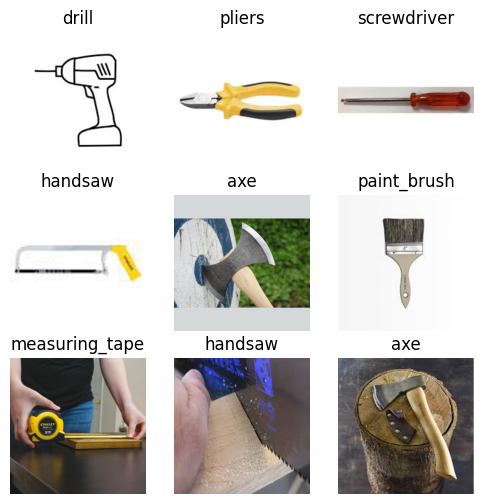

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(9):  # Grid de 9 imágenes (3x3)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(train_images[i].astype(np.uint8))
  plt.title(class_names[train_labels[i]])
  plt.axis("off")

### 2.2 Análisis de dimensiones
Analisis de dimensión de las imagenes en el dataset, como el ancho, alto y numero de canales de color

In [ ]:
def dimension_analysis():
  # Recorrer el dataset para obtener las dimensiones de las imágenes
  widths = []
  heights = []
  num_channels = set()

  for i in range(len(train_images)): # Análisis al sexto batch
      batch_size = train_images.shape[0]
      for i in range(batch_size):
          image = train_images[i]
          height, width, channels = image.shape
          heights.append(height)
          widths.append(width)
          num_channels.add(channels)

  # Calcular estadísticas de dimensiones
  min_width = min(widths)
  max_width = max(widths)
  avg_width = sum(widths) / len(widths)

  min_height = min(heights)
  max_height = max(heights)
  avg_height = sum(heights) / len(heights)

  num_channels = list(num_channels)
  num_channels.sort()

  # Imprimir los resultados
  print("Dimensiones de las imágenes:")
  print(f"Ancho mínimo: {min_width}px")
  print(f"Ancho máximo: {max_width}px")
  print(f"Ancho promedio: {avg_width:.2f}px")
  print()
  print(f"Altura mínima: {min_height}px")
  print(f"Altura máxima: {max_height}px")
  print(f"Altura promedio: {avg_height:.2f}px")
  print()
  print(f"Número de canales de color: {num_channels}")

dimension_analysis()

Dimensiones de las imágenes:
Ancho mínimo: 224px
Ancho máximo: 224px
Ancho promedio: 224.00px

Altura mínima: 224px
Altura máxima: 224px
Altura promedio: 224.00px

Número de canales de color: [3]


Al ejecutar la funcion **image_dataset_from_directory** para formar el dataset, esta necesita que todas las imagenes sean del mismo tamaño, por lo que se normalizan al momento de la creación del dataset


### 2.3 Análisis de distribución de categorías
Examinar la distribución de las categorías de herramientas en el dataset. Contar imagenes en cada categoría y representar en un grafico de barras o diagrama circular para visualizar el desequilibrio de clases, si lo hay.


In [ ]:
def plot_bar_chart(class_names, class_counts, threshold=200):
    plt.figure(figsize=(8, 4))
    plt.bar(class_names, class_counts)
    plt.xlabel("Clase")
    plt.ylabel("Número de imágenes")
    plt.title("Distribución en cada categoría")
    plt.xticks(rotation=45)

    # Add a threshold line
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold ({threshold})")
    plt.legend()

    plt.show()

def plot_pie_chart(class_names, class_counts):
    plt.figure(figsize=(6, 6))
    plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.title("Distribución en cada categoría")
    plt.axis('equal')
    plt.show()

In [ ]:
def get_data():
  # Contar el número de imágenes en cada clase
  class_counts = np.zeros(len(class_names))


  class_counts = np.bincount(train_labels, minlength=len(class_names))

  # Normalizar los conteos a porcentajes
  class_percentages = (class_counts / np.sum(class_counts)) * 100

  for i in range(len(class_names)):
    print(class_names[i], ':', class_counts[i])

  return class_counts, class_percentages

class_counts, class_percentages = get_data()


axe : 253
claw_hammer : 291
drill : 223
handsaw : 229
measuring_tape : 222
paint_brush : 204
pliers : 222
screwdriver : 202
shovel : 269
square_tool : 217


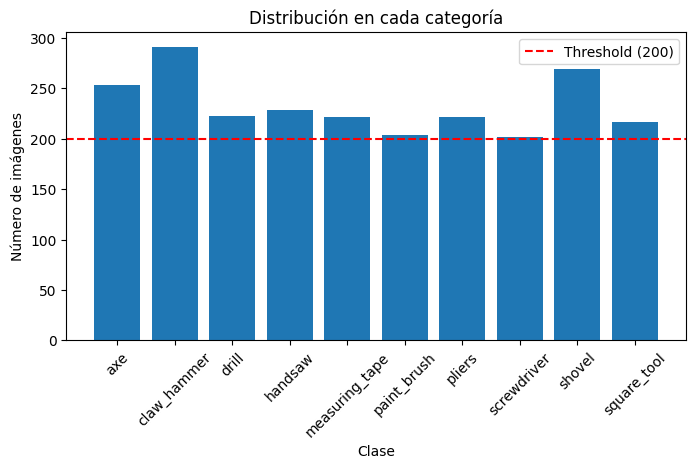

In [ ]:
# Visualizar la distribución en cada categoría
plot_bar_chart(class_names, class_counts)

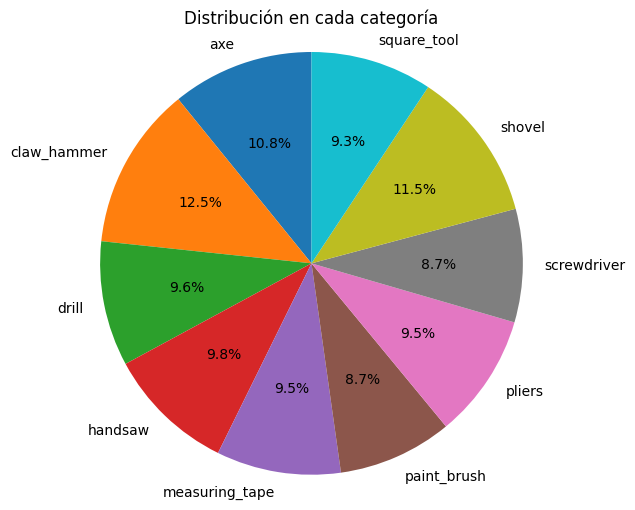

In [ ]:
plot_pie_chart(class_names, class_percentages)

## 3. Balanceamiento de las clases
Submuestreo => labels1 , images1

Sobremuestro => labels2, images2

Generación sintetica => train_images_resampled, train_labels_resampled

### 3.1 Submuestreo aleatorio
Reducir aleatoriamente el numero de muestras de la clase dominante para que se equilibre con las clases minoritarias


[253 291 223 229 222 204 222 202 269 217]
[219 219 219 219 219 204 219 202 219 217]


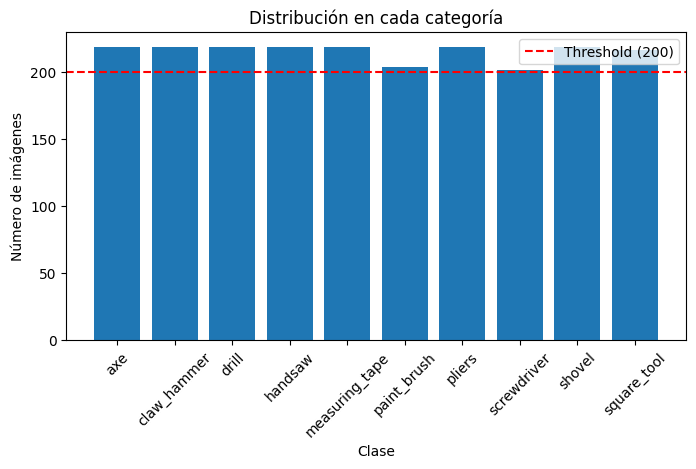

In [ ]:
def balancear_clases_submuestreo(images,labels):
  class_names_np = np.array(class_names)
  class_counts = np.bincount(labels, minlength=len(class_names_np))
  aux = 0
  for i in range(len(class_counts)):
    aux += class_counts[i]
  aux=aux/len(class_counts)
  #print(aux)

  dominantes = []
  difference = []

  for i in range(len(class_counts)):
    if class_counts[i] > aux:
      difference.append(int(class_counts[i]-aux))
      dominantes.append(class_names_np[i])

  index = []
  for i in range(len(dominantes)):
    a = np.where(class_names_np == dominantes[i])[0]
    index.append(int(a))

  indices_to_delete = []
  for i in range(len(index)):
      cont = difference[i]
      for j in range(len(labels)):
          if index[i] == labels[j]:
              if cont > 0:
                  indices_to_delete.append(j)
                  cont -= 1

 #print(index)

  filtered_images = []
  filtered_labels = []

  for i in range(len(images)):
        if i not in indices_to_delete:
            filtered_images.append(images[i])
            filtered_labels.append(labels[i])

  return filtered_labels, filtered_images 


conteo_c = np.bincount(train_labels, minlength=len(class_names))
print(conteo_c)

labels1, images1 = balancear_clases_submuestreo(train_images,train_labels)
labels1, images1 = balancear_clases_submuestreo(images1, labels1)
labels1, images1 = balancear_clases_submuestreo(images1, labels1)

conteo_c3 = np.bincount(labels1, minlength=len(class_names))
print(conteo_c3)

plot_bar_chart(class_names, conteo_c3)

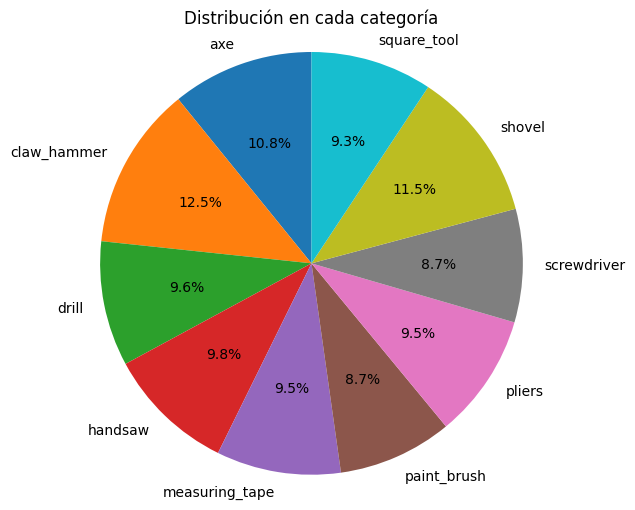

In [ ]:
plot_pie_chart(class_names, conteo_c)

### 3.2 Sobremuestreo aleatorio
 Implica duplicar muestras para las clases minoritarias hasta que el conjunto de datos esté equilibrado

[253 291 223 229 222 204 222 202 269 217]
[253 291 252 252 252 252 252 252 269 252]


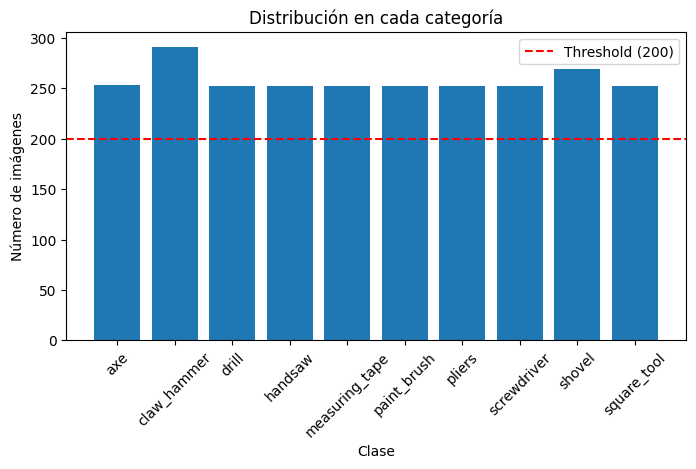

In [ ]:
def balancear_clases_sobremuestreo(images,labels):
  class_names_np = np.array(class_names)
  class_counts = np.bincount(labels, minlength=len(class_names_np))
  aux = 0
  for i in range(len(class_counts)):
    aux += class_counts[i]
  aux=aux/len(class_counts)
  #print(aux)

  minoritaria = []
  difference = []

  for i in range(len(class_counts)):
    if class_counts[i] < aux:
      difference.append(int(aux-class_counts[i]))
      minoritaria.append(class_names_np[i])

  index = []
  for i in range(len(minoritaria)):
    a = np.where(class_names_np == minoritaria[i])[0]
    index.append(int(a))

  indices_to_delete = []
  for i in range(len(index)):
      cont = difference[i]
      for j in range(len(labels)):
          if index[i] == labels[j]:
              if cont > 0:
                  indices_to_delete.append(j)
                  cont -= 1

  #print(index)

  filtered_images = []
  filtered_labels = []

  for i in range(len(index)):
    indices_clase_minoritaria = np.where(np.array(labels) == index[i])[0]
    imagenes_replicadas = np.random.choice(indices_clase_minoritaria, difference[i], replace=True)
    for i in range(len(imagenes_replicadas)):
      filtered_labels.append(labels[imagenes_replicadas[i]])
      filtered_images.append(images[imagenes_replicadas[i]])

  filtered_labels.extend(labels)
  filtered_images.extend(images)

  return filtered_labels, filtered_images 


conteo_c = np.bincount(train_labels, minlength=len(class_names))
print(conteo_c)

labels2, images2 = balancear_clases_sobremuestreo(train_images,train_labels)
labels2, images2 = balancear_clases_sobremuestreo(images2, labels2)
labels2, images2 = balancear_clases_sobremuestreo(images2, labels2)



conteo_c1 = np.bincount(labels2, minlength=len(class_names))
print(conteo_c1)

plot_bar_chart(class_names, conteo_c1)

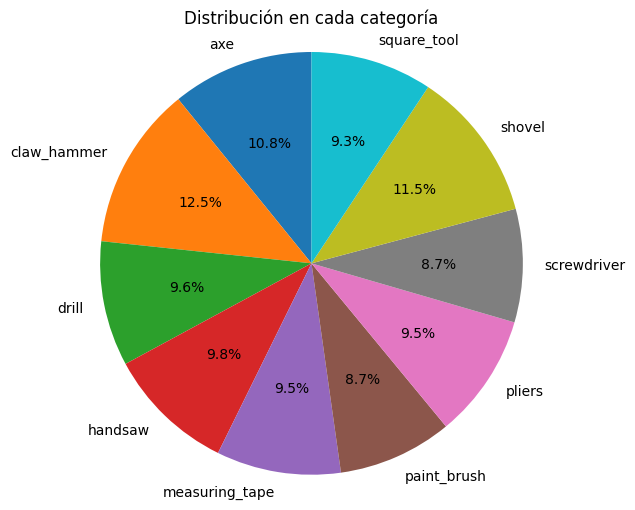

In [ ]:
plot_pie_chart(class_names, conteo_c)

### 3.3 Generación sintética de muestras
e utilizan algoritmos como SMOTE (Synthetic Minority Over-sampling Technique) para crear muestras sintéticas basadas en las características de las muestras existentes de las clases minoritarias

In [ ]:
def save_temp_dataset(images, labels, class_names, name: str):
  out_path = os.path.join(path, f"out/dataset/{name}_tools_dataset.h5")
  with h5py.File(out_path, "w") as hf:
    hf.create_dataset("images", np.shape(images), data=images)
    hf.create_dataset("labels", np.shape(labels), data=labels)
    hf.create_dataset("classes", np.shape(class_names), data=class_names)

In [ ]:
def sliced(iterable, start: float | int = 0, stop: float | int = None):
  size = len(iterable)

  if isinstance(start, float):
    start = round(size * start)
  if isinstance(stop, float):
    stop = round(size * stop)
  else:
    stop = np.clip(1 if stop is None else stop, 1, size)

  size = len(iterable)
  return iterable[start:stop]

Total después de SMOTE: 2910
[291 291 291 291 291 291 291 291 291 291]
[253 291 223 229 222 204 222 202 269 217]


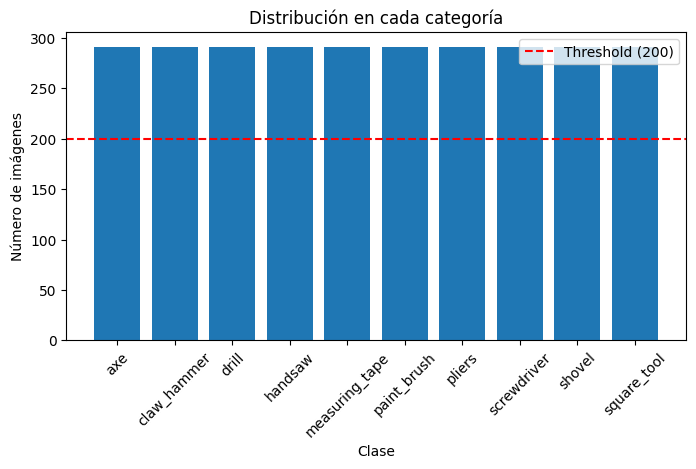

In [ ]:
# Step 1: Import the necessary libraries
from imblearn.over_sampling import SMOTE

def generacion_sintentica(images,labels):
  # Step 2: Reshape the image data and labels
  train_images = np.array(images)  # Convert the image list to a numpy array
  n_samples, height, width, channels = train_images.shape
  train_images_reshaped = train_images.reshape((n_samples, height * width * channels))
  train_labels_reshaped = np.array(labels)

  # Step 3: Apply SMOTE
  smote = SMOTE()
  train_images_resampled, train_labels_resampled = smote.fit_resample(train_images_reshaped, train_labels_reshaped)

  # Step 4: Reshape the resampled image data back to the original shape
  train_images_resampled = train_images_resampled.reshape((-1, height, width, channels))

  # Step 5: Verify the new shape and number of samples
  n_samples_resampled = train_images_resampled.shape[0]
  print(f"Total después de SMOTE: {n_samples_resampled}")

  return train_images_resampled, train_labels_resampled

train_images_resampled, train_labels_resampled = generacion_sintentica(train_images, train_labels)

conteo_c2 = np.bincount(train_labels_resampled, minlength=len(class_names))
conteo_cf = np.bincount(train_labels, minlength=len(class_names))
print(conteo_c2)
print(conteo_cf)
plot_bar_chart(class_names, conteo_c2)

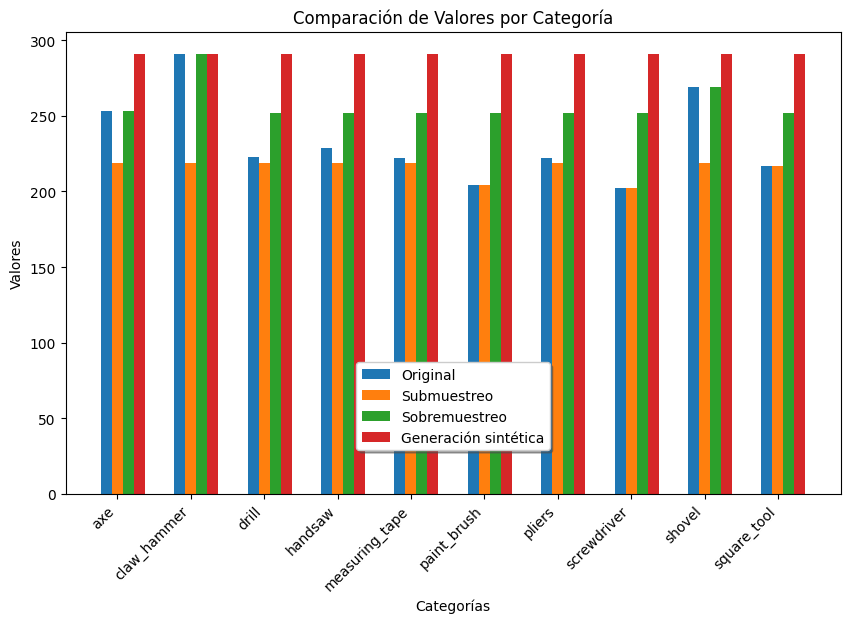

In [ ]:
# Configuración del gráfico
espacio_categorias = 0.4
ancho_barras = (1 - espacio_categorias) / 4
indice = np.arange(len(class_names))

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))

plt.bar(indice , conteo_cf, width=ancho_barras, label='Original')
plt.bar(indice + ancho_barras, conteo_c3, width=ancho_barras, label='Submuestreo')

plt.bar(indice + 2* ancho_barras, conteo_c1, width=ancho_barras, label='Sobremuestreo')
plt.bar(indice + 3* ancho_barras, conteo_c2, width=ancho_barras, label='Generación sintética')



# Personalizar el gráfico
plt.xlabel('Categorías')
plt.ylabel('Valores')
plt.title('Comparación de Valores por Categoría')
plt.xticks(indice + ancho_barras, class_names)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3), fancybox=True, shadow=True)


plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
# Mostrar el gráfico
plt.show()





In [ ]:
import matplotlib.pyplot as plt

def visualize_last_images_with_label(images, labels, target_label, num_images=10):
    """
    Visualizes the last images with a specific label in the array.
    
    Args:
        images (numpy.ndarray): The array of images in shape [n_samples, height, width, channels].
        labels (numpy.ndarray): The array of labels corresponding to the images.
        target_label: The label of the images to visualize.
        num_images (int): The number of images to visualize. Defaults to 10.
    """
    last_images_with_label = images[labels == target_label][-num_images:]
    last_labels_with_label = labels[labels == target_label][-num_images:]

    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))

    for i in range(num_images):
        image = last_images_with_label[i]
        label = class_names[last_labels_with_label[i]]
        ax = axes[i]

        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

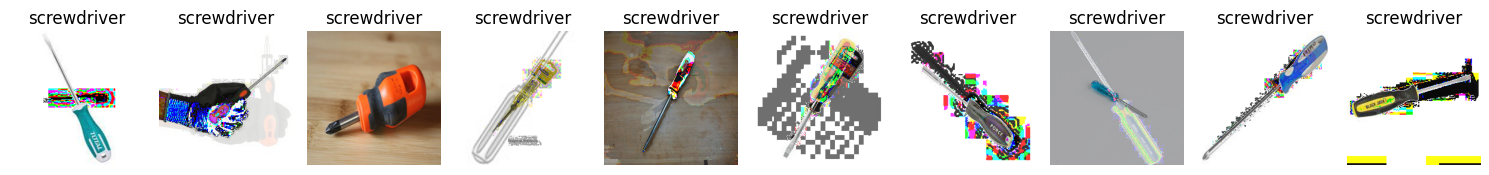

In [ ]:
visualize_last_images_with_label(train_images_resampled, train_labels_resampled, target_label=7, num_images=10)


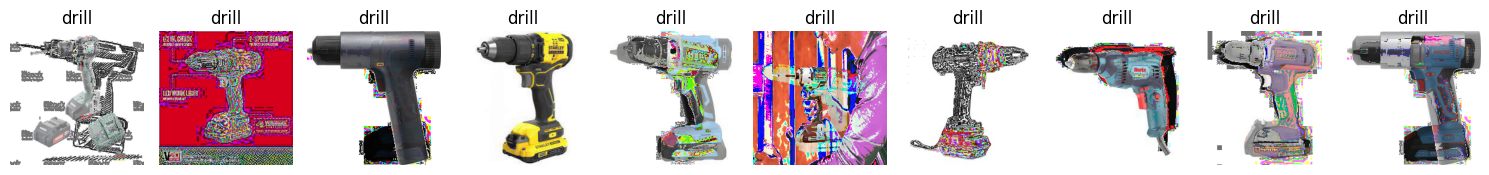

In [ ]:
visualize_last_images_with_label(train_images_resampled, train_labels_resampled, target_label=2, num_images=10)


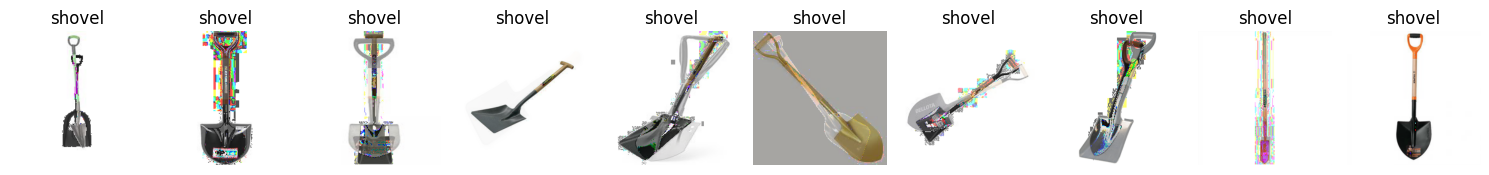

In [ ]:
visualize_last_images_with_label(train_images_resampled, train_labels_resampled, target_label=8, num_images=10)


In [ ]:
# del train_images_resampled
# del train_labels_resampled

## 4. Data augmentation

### 4.1 Espejo horizontal 
voltear imagen horizontalmente

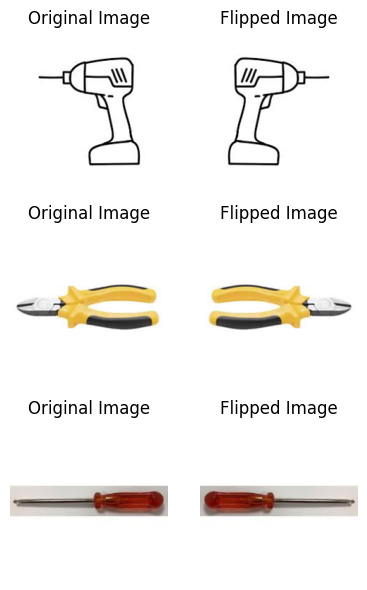

In [ ]:
 
import matplotlib.pyplot as plt

def voltear_imagenes(arr_imgs):  # crea un arreglo de imagenes con las imagenes volteadas 
  flipped_images = []
  for i in range(len(arr_imgs)):
    # Input image
    image = np.array(arr_imgs[i])

    flipped_image = image[:, ::-1, :]  # Flip horizontally
    flipped_images.append(flipped_image)

  return flipped_images

flipped_images = voltear_imagenes(train_images)

def compare_images(train_images, flipped_images, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(num_images, 2, figsize=(4, 2 * num_images))
    
    for i, idx in enumerate(indices):
        image = train_images[idx]
        flipped_image = flipped_images[idx]
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(flipped_image)
        axes[i, 1].set_title('Flipped Image')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

indices = [0,1,2]
compare_images(train_images, flipped_images, indices)


In [ ]:
# save_temp_dataset(
#   images=flipped_images,
#   labels=train_labels,
#   class_names=class_names,
#   name="flipped"
# )

# del flipped_images

### 4.2 Rotación
Rotar la imagen en un angulo especifico, creando nuevas imagenes rotadas.

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

def rotated_images(images):
    rotated = []
    imageDataGen = ImageDataGenerator(rotation_range=90)

    for i in range(len(images)):
        imageNew = np.expand_dims(images[i], 0)
        iterator = imageDataGen.flow(imageNew, batch_size=1)
        rotated.extend(iterator.next())

    rotated = np.squeeze(rotated).astype(np.uint8)  # Convert images to integers
    return rotated

rotated_images = rotated_images(train_images)

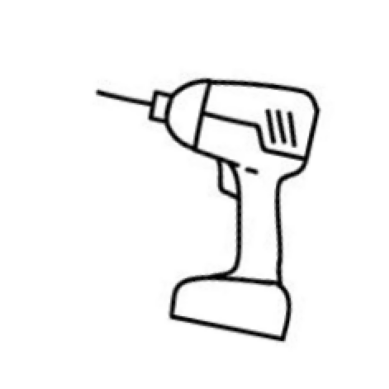

In [ ]:
display_image(rotated_images[0])

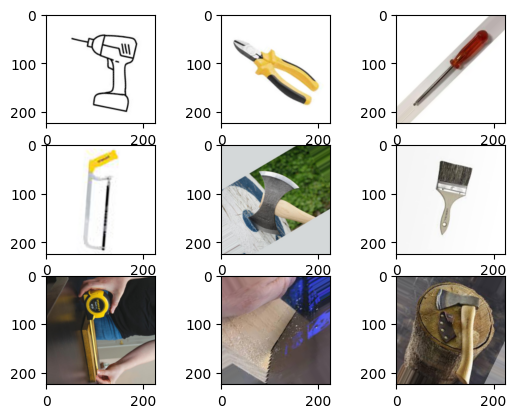

[2 6 7 3 0 5 4 3 0 1]


In [ ]:
import matplotlib.pyplot as plt

for i in range(9):
    # Define the subplot
    plt.subplot(330 + 1 + i)
    
    # Reshape the image to remove the extra dimension
    image = rotated_images[i]
    
    # Convert back to unsigned integers for viewing
    image = image.astype('uint8')
    
    # Plot the image
    plt.imshow(image)
    
# Visualize the figure
plt.show()

print(train_labels[0:10])

class_names_idx = list(range(len(class_names)))
conteo_c = np.bincount(train_labels,minlength=len(class_names_idx))

In [ ]:
# save_temp_dataset(
#   images=rotated_images,
#   labels=rotated_labels,
#   class_names=class_names,
#   name="rotated"
# )

# del rotated_images
# del rotated_labels

### 4.3 Desplazamiento y recorte
Desplazar la imagen en diferentes direcciones y se recorta para generar imagenes con diferentes posiciones de los objetos


In [ ]:
import cv2
import numpy as np

def displace_images(train_images):
    augmented_images = []
    
    for image in train_images:
        # Desplazamiento aleatorio
        rows, cols = image.shape[:2]
        dx = np.random.randint(-80, 80)
        dy = np.random.randint(-80, 80)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        shifted_image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
        
        cropped_image = shifted_image
        augmented_images.append(cropped_image)
    
    return augmented_images

# Uso de la función
displaced_images = displace_images(train_images)
print(len(displaced_images))


2332


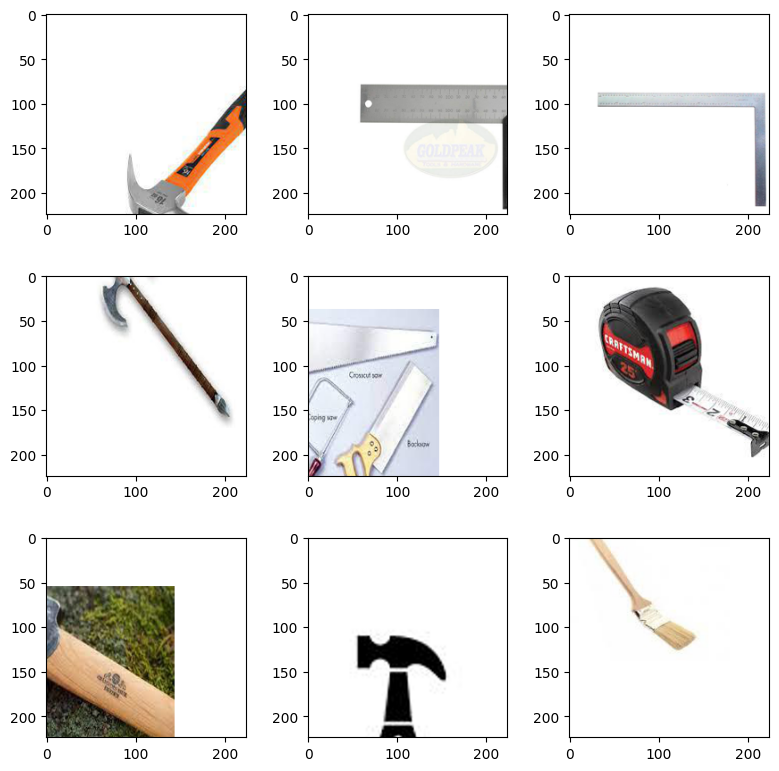

In [ ]:
import matplotlib.pyplot as plt

# Obtén las primeras nueve imágenes aumentadas
first_nine_images = displaced_images[:19]

# Crea una cuadrícula de subplots para mostrar las imágenes
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.tight_layout()

# Itera sobre los subplots y muestra las imágenes
for i, ax in enumerate(axes.flat):
    ax.imshow(first_nine_images[i+9], cmap='gray')

# Muestra la cuadrícula de subplots
plt.show()


In [ ]:
# save_temp_dataset(
#   images=augmented_images,
#   labels=train_labels,
#   class_names=class_names,
#   name="displaced"
# )

# del augmented_images

### 4.4 Cambio de brillo
Se ajusta el brillo de la imagen para crear variaciones en la iluminacion


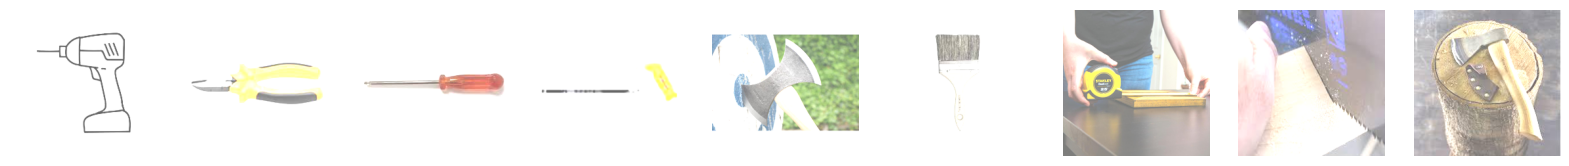

In [ ]:
def ajust_brightness(images, brightness):
  brightened_images = []
  for i in range(len(images)):
    bright = tf.image.adjust_brightness(images[i], brightness)
    brightened_images.append(bright)

  return brightened_images

brightened_images = ajust_brightness(train_images, 0.4)

fig = plt.figure(figsize=(20, 12))

for i in range(9):
  image = brightened_images[i]
  ax = fig.add_subplot(1, 9, i+1)
  ax.imshow(image)
  ax.axis('off')
    
plt.show()

In [ ]:
# save_temp_dataset(
#   images=brightned_images,
#   labels=train_labels,
#   class_names=class_names,
#   name="brightened"
# )

# del brightned_images

### 4.5 Desenfoque y ruido
Se aplica desenfoque o se agrega ruido a la imagen para disimular diferentes condiciones de captura


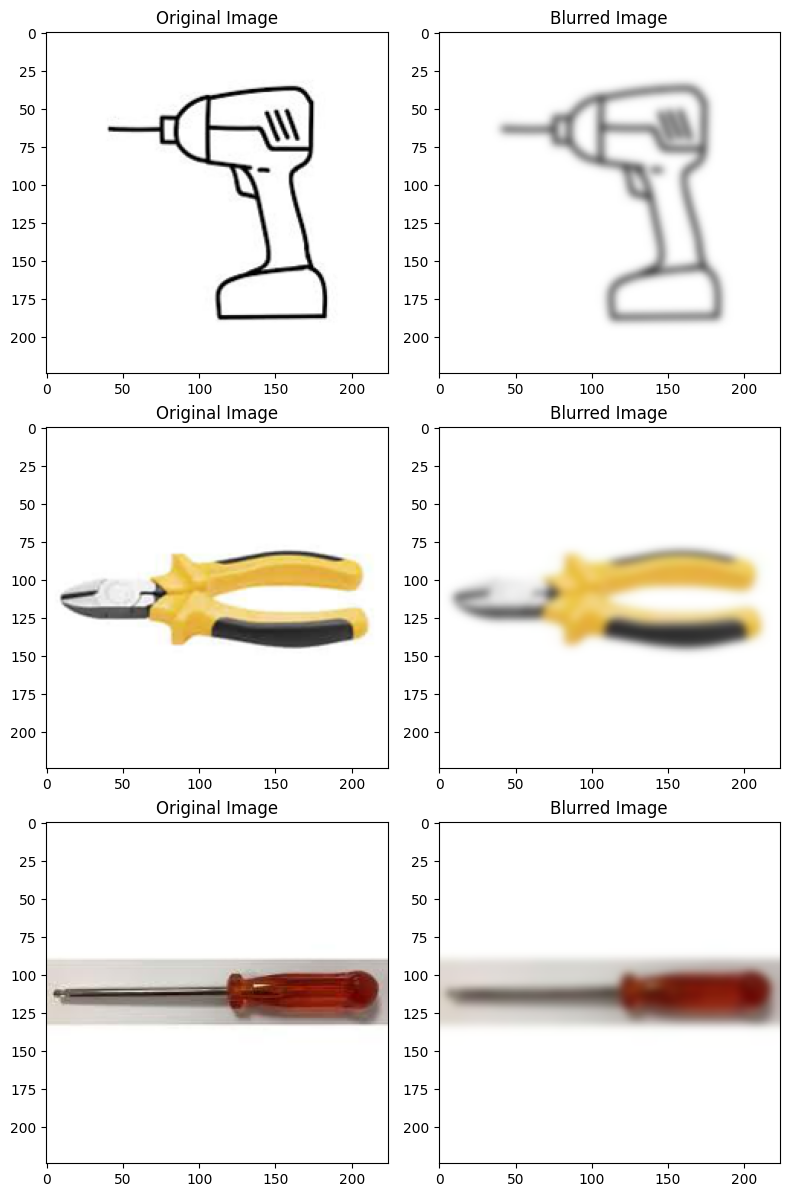

In [ ]:
def blur(images):
  # Apply a Gaussian blur
  ksize = 15  # Larger kernel size for increased blur
  sigmaX = 0  # Standard deviation in X direction (0 for automatic calculation)}
  blurred_images = []
  for i in range(len(images)):
    blurred_image = cv2.GaussianBlur(train_images[i], (ksize, ksize), sigmaX)
    blurred_images.append(blurred_image)

  return blurred_images


blurred_images = blur(train_images)

# Define the number of images you want to display
num_images = 3

# Create a figure with multiple subplots
fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(8, num_images*4))

# Iterate over the images and display them
for i in range(num_images):
    # Display the original image
    axs[i, 0].imshow(train_images[i])
    axs[i, 0].set_title('Original Image')

    # Display the saturated image
    axs[i, 1].imshow(blurred_images[i])
    axs[i, 1].set_title('Blurred Image')

    # Adjust spacing between subplots
    plt.tight_layout()
    ax.axis('off')

# Show the plot
plt.show()


In [ ]:
# save_temp_dataset(
#   images=blurred_images,
#   labels=train_labels,
#   class_names=class_names,
#   name="blurred"
# )

# del blurred_images

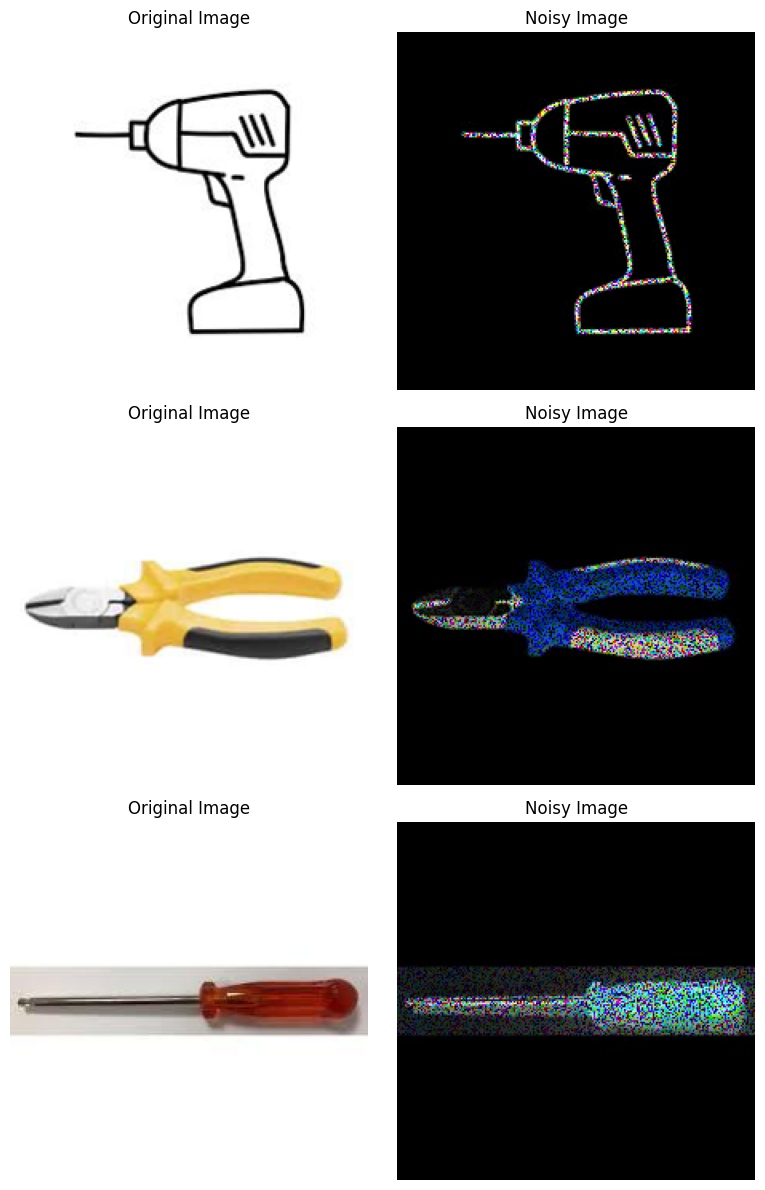

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the array train_images
# train_images = [...]

def add_noise(images):
    noisy_images = []
    
    # Iterate over the images
    for i in range(len(images)):
        image = images[i]

        # Generate salt-and-pepper noise
        noise = np.random.choice([0, 255], size=image.shape, p=[0.35, 0.65])

        # Add the noise to the image
        noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)

        # Calculate the noise component
        noise_component = noisy_image - image
        noisy_images.append(noise_component)
    
    return noisy_images

noisy_images = add_noise(train_images)

# Define the number of images you want to display
num_images = 3

# Create a figure with multiple subplots
fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(8, num_images*4))

# Iterate over the images and display them
for i in range(num_images):
    # Display the original image
    axs[i, 0].imshow(train_images[i])
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    # Display the noisy image
    axs[i, 1].imshow(noisy_images[i])
    axs[i, 1].set_title('Noisy Image')
    axs[i, 1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# save_temp_dataset(
#   images=noisy_images,
#   labels=train_labels,
#   class_names=class_names,
#   name="noisy"
# )

# del noisy_images

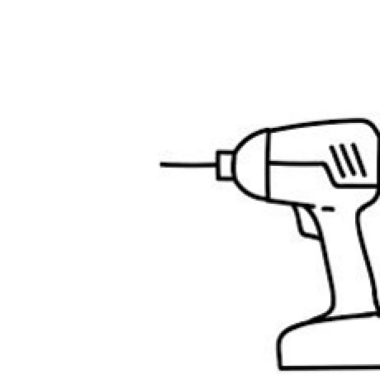

In [ ]:
display_image(displaced_images[0])

### Train images (augmented)

In [ ]:
def random_image(images, labels):
  idx = random.randrange(len(images))
  return images[idx], labels[idx]


def display_random(images, labels):
  image, label = random_image(images, labels)
  display_image(image, label=class_names[label])

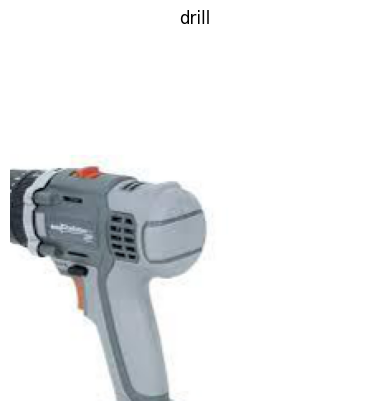

In [ ]:
a = displaced_images
b = train_labels
display_random(a, b)

In [ ]:
aug_images = np.concatenate((flipped_images, displaced_images, brightened_images, blurred_images, noisy_images, rotated_images))
aug_labels = np.tile(train_labels, 6)

print(len(aug_images))
print(len(aug_labels))

aug_images, aug_labels = zip_shuffle(aug_images, aug_labels)
cap = 5000
aug_images = aug_images[:cap]
aug_labels = aug_labels[:cap]

13992
13992


In [ ]:
list(map(len, (flipped_images, displaced_images, brightened_images, blurred_images, noisy_images, rotated_images)))

[2332, 2332, 2332, 2332, 2332, 2332]

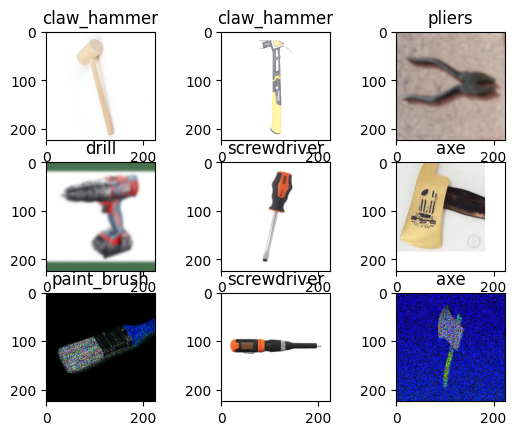

In [ ]:
for i in range(9):
    # Define the subplot
    plt.subplot(330 + 1 + i)
    
    # Reshape the image to remove the extra dimension
    image = aug_images[i]
    
    # Convert back to unsigned integers for viewing
    image = image.astype('uint8')
    
    # Plot the image
    plt.imshow(image)
    plt.title(class_names[aug_labels[i]])

    
# Visualize the figure
plt.show()

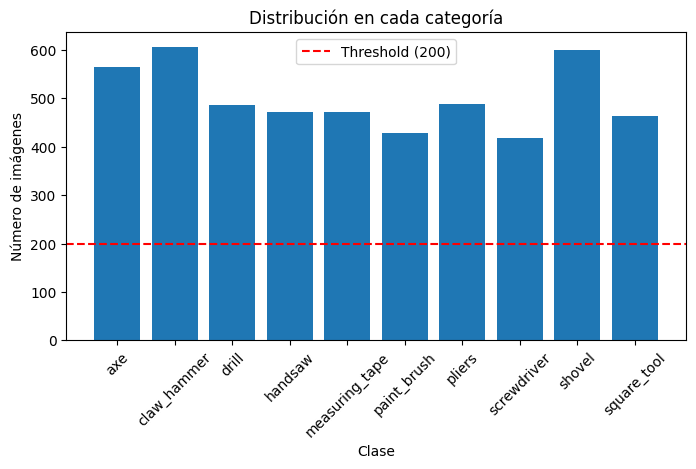

In [ ]:
conteo_c = np.bincount(aug_labels,minlength=len(class_names))
plot_bar_chart(class_names, conteo_c)

In [ ]:
# aug_images = tf.image.rgb_to_grayscale(aug_images)

In [ ]:
augmented_dataset_path = os.path.join(path, "out/dataset/augmented_tools_dataset.h5")
save_temp_dataset(aug_images, aug_labels, class_names, name="augmented")

In [ ]:
all_images = np.concatenate((train_images, flipped_images, displaced_images, brightened_images, blurred_images, noisy_images, rotated_images))
all_labels = np.tile(train_labels, 8)

print("total imagenes: ", len(all_images))
print("total etiquetas: ",len(all_labels))
print(len(train_images))
print(len(flipped_images))
print(len(rotated_images))
print(len(displaced_images))
print(len(brightened_images))
print(len(blurred_images))
print(len(noisy_images))

total imagenes:  16324
total etiquetas:  18656
2332
2332
2332
2332
2332
2332
2332


In [ ]:
#FUNCION SOBREMUESTREO balancear_clases_sobremuestreo(images,labels)  => labels , images
#FUNCION SUBMUESTREO balancear_clases_submuestreo(images,labels)  => labels, images
#FUNCION GENERACIÓN SINTÉTICA generacion_sintentica(images,labels)  => images, labels
#Todos retornan arreglo de imagenes y etiquetas

## 5. Fase 1: Modelo propio

## 6. Fase 2: Aplicación de Transfer Learning
Se aprovecha el conocimiento adquirido por un modelo previamente entrenado en 
una tarea relacionada y se aplica a una nueva tarea o dominio




## 7. Fase 3: Selección de modelo


## 8. Fase 4: Front-end